Pemriksaan versi tensor flow dan ketersedian dari gpu

In [ ]:
from packaging.version import Version
import warnings
import tensorflow as tf

# Memeriksa versi TensorFlow
assert Version(tf.__version__) >= Version('1.0')
print("TensorFlow Version: {}".format(tf.__version__))

# Memeriksa apakah ada GPU yang tersedia
if not tf.config.list_physical_devices('GPU'):
    warnings.warn("No GPU Found: Please ensure you have installed TensorFlow correctly")
else:
    print("Default GPU Device: {}".format(tf.test.gpu_device_name()))


TensorFlow Version: 2.15.0
Default GPU Device: /device:GPU:0


# Import Libraries

In [ ]:
# Arsitektur CNN
from tensorflow.keras import layers, models, callbacks

# Generator dan Praproses Data
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

# Fungsi Loss
from keras.metrics import sparse_categorical_crossentropy

# Visualisasi
import matplotlib.pyplot as plt
import numpy as np

# Confusion matrix
from sklearn.metrics import classification_report, confusion_matrix

# Pengaturan Direktori
import os

# Log
import pandas as pd

# Pra-pelatihan

In [ ]:
# Membuat nama kelas berdasarkan urutan folder
class_names = [ 'ain', 'alif', 'ba', 'dal', 'dhod', 'dzal',
                'dzho', 'fa', 'ghoin', 'ha', 'ha\'', 'hamzah', 'jim',
                'kaf', 'kho', 'lam', 'lamalif', 'mim', 'nun', 'qof',
                'ro', 'shod', 'sin', 'syin', 'ta', 'tho', 'tsa',
                'wawu', 'ya', 'zain']

## Arsitektur CNN

arsitektur cnn ini dibuat untuk tugas klasifikasi yaitu dengan 30 kelas, dan 11 lapisan
11 lapisan terbuat ada
Lapisan convolusional -diikuti dengan pooling untuk menangkap fitur spasial gambar- setelah itu di Lapisan Flatten mengubah output dari lapisan sebelumnya yang berbentuk multi-dimensi menjadi satu dimensi (vector) dan melewati beberapa lapisan fully connected sebelum akhirnya menghasilkan prediksi kelas dengan lapisan output softmax.


![arsitektur](arsitektur_baru.png)

In [ ]:
# Membuat arsitektur CNN
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), padding='valid', activation='relu', input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2), strides=(2,2), padding='valid'))
model.add(layers.Conv2D(64, (3, 3), padding='valid', activation='relu'))
model.add(layers.MaxPooling2D((2, 2), strides=(2,2), padding='valid'))
model.add(layers.Conv2D(128, (3, 3), padding='valid', activation='relu'))
model.add(layers.MaxPooling2D((2, 2), strides=(2,2), padding='valid'))
model.add(layers.Conv2D(256, (3, 3), padding='valid', activation='relu'))
model.add(layers.MaxPooling2D((2, 2), strides=(2,2), padding='valid'))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(30, activation='softmax'))

# Melihat detail arsitektur
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 17, 17, 128)       0



Total Parameter: 6,826,846 – jumlah semua parameter dari semua lapisan.
Trainable Params: 6,826,846 – semua parameter dalam model dapat dilatih.
Non-trainable Params: 0 – tidak ada parameter yang tidak dapat dilatih.
Model ini memiliki empat lapisan konvolusi dengan lapisan pooling di antaranya, diikuti oleh lapisan flatten, dan dua lapisan fully connected. Outputnya adalah klasifikasi ke dalam 30 kelas dengan aktivasi softmax pada lapisan output.


## Dataset | Praproses dan Augmentasi

In [ ]:
from google.colab import files
import zipfile
import os

# Unggah file ZIP
uploaded = files.upload()

# Ekstrak file ZIP
for file_name in uploaded.keys():
    with zipfile.ZipFile(file_name, 'r') as zip_ref:
        zip_ref.extractall('/content')

# Periksa apakah file sudah diekstrak
os.listdir('/content')


Saving dataset.zip to dataset.zip


['.config', 'dataset', 'dataset.zip', 'sample_data']

In [ ]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Pengaturan direktori
PATH = 'dataset'
VAL_DATA = 'test_mixed'
TOTAL_TRAIN_DATA = 1680
TRAIN_DIR = os.path.join(PATH, 'train')
VALIDATION_DIR = os.path.join(PATH, VAL_DATA)

BATCH_SIZE = 56
IMG_SIZE = (150, 150)

# Membuat generator pelatihan
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    shear_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    target_size=IMG_SIZE,
    color_mode='rgb'
)

validation_datagen = ImageDataGenerator(rescale=1./255)

# Membuat generator validasi
validation_generator = validation_datagen.flow_from_directory(
    VALIDATION_DIR,
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    target_size=IMG_SIZE,
    color_mode='rgb'
)


Found 1680 images belonging to 30 classes.
Found 420 images belonging to 30 classes.


![Augmentasi Data](augmentasi.png)

## Pelatihan

Pelatihan ini berlangsung selama 105 epoch. Model dilatih menggunakan generator data pelatihan dan validasi

In [ ]:
# Callback untuk menyimpan model setiap epoch
model_save_callback = callbacks.ModelCheckpoint('models/model_{val_accuracy:.3f}_{accuracy:.3f}.h5', save_best_only=False, save_weights_only=False, monitor='val_accuracy')

# Inisialisasi metrik
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Pelatihan!
history = model.fit( train_generator,
                     steps_per_epoch=train_generator.n // train_generator.batch_size,
                     epochs=105,
                     validation_data=validation_generator,
                     validation_steps= validation_generator.n // validation_generator.batch_size,
                     callbacks=[
                         model_save_callback
                     ]
                   )

Epoch 1/105
30/30 [==============================] - ETA: 0s - loss: 3.4278 - accuracy: 0.0304

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


30/30 [==============================] - 17s 353ms/step - loss: 3.4278 - accuracy: 0.0304 - val_loss: 3.3919 - val_accuracy: 0.0510
Epoch 2/105
30/30 [==============================] - 12s 398ms/step - loss: 3.3390 - accuracy: 0.0583 - val_loss: 3.0355 - val_accuracy: 0.1122
Epoch 3/105
30/30 [==============================] - 12s 401ms/step - loss: 3.1850 - accuracy: 0.1077 - val_loss: 2.7587 - val_accuracy: 0.1735
Epoch 4/105
30/30 [==============================] - 13s 421ms/step - loss: 3.0246 - accuracy: 0.1256 - val_loss: 2.5815 - val_accuracy: 0.2168
Epoch 5/105
30/30 [==============================] - 12s 404ms/step - loss: 2.8660 - accuracy: 0.1554 - val_loss: 2.4370 - val_accuracy: 0.2449
Epoch 6/105
30/30 [==============================] - 12s 394ms/step - loss: 2.7955 - accuracy: 0.1560 - val_loss: 2.4367 - val_accuracy: 0.2704
Epoch 7/105
30/30 [==============================] - 13s 437ms/step - loss: 2.5908 - accuracy: 0.2185 - val_loss: 2.3701 - val_accuracy: 0.2449
Epoc

## Visualisasi metrik

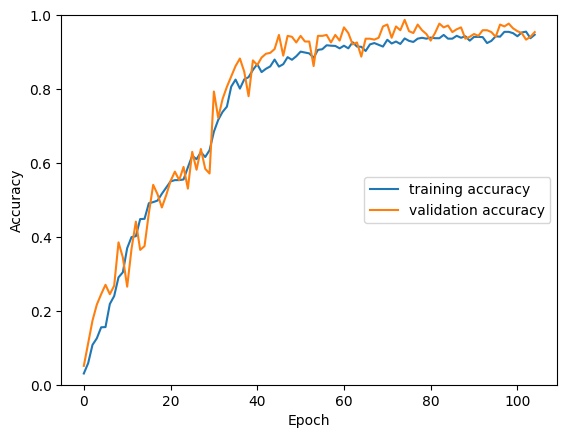

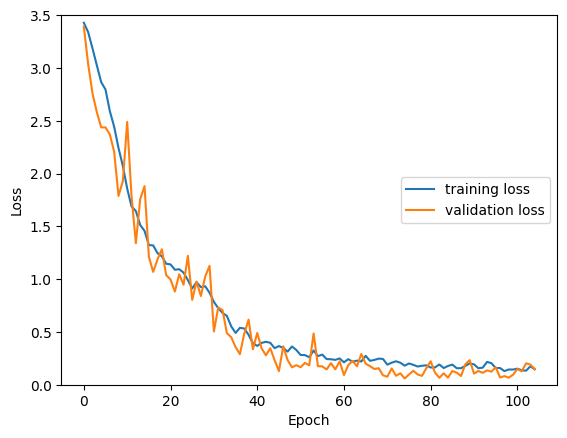

In [ ]:
# Menyimpan history pelatihan
pd.DataFrame(history.history).to_csv('history.csv')

# Memvisualisasikan metrik akurasi selama pelatihan
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0., 1])
plt.legend(loc='right')
plt.savefig('train_val_acc_augmentation.png')
plt.show()

# Memvisualisasikan metrik loss selama pelatihan
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0., 3.5])
plt.legend(loc='right')
plt.savefig('train_val_loss_augmentation.png')
plt.show()

-	pertama Grafik akurasi training dan validasi menunjukkan bahwa model yang dilatih mencapai akurasi yang tinggi pada kedua dataset pelatihan dan validasi setelah sekitar 50 epoch. Tidak ada tanda-tanda overfitting yang signifikan, karena akurasi validasi tetap sejalan dengan akurasi pelatihan. Ini menunjukkan bahwa model yang baik dan dapat melakukan klasifikasi
-	kedua Grafik ini menunjukkan bahwa model yang dilatih berhasil mencapai nilai loss yang rendah dilihat pada kedua dataset pelatihan dan validasi setelah sekitar 50 epoch. Penurunan yang stabil dan konsisten pada validation loss menunjukkan bahwa model tidak mengalami overfitting yang signifikan dan dapat generalisasi dengan baik pada data baru.


# Evaluasi Model

memuat model neural network yang telah dilatih sebelumnya dari file hijaiyah.h5.

In [ ]:
# load model terbaik
loaded_model = models.load_model('models/hijaiyah.h5')

 Fungsi ini mengembalikan tensor gambar yang telah diproses siap untuk prediksi.


In [ ]:
# Membuat fungsi load image untuk pengujian
def load_image(img_path):
  # Praproses data uji
  img = load_img(img_path, target_size=(150,150,3))
  img_tensor = img_to_array(img)
  img_tensor = np.expand_dims(img_tensor, axis=0)
  img_tensor /= 255.0

  return img_tensor

In [ ]:
# Membuat generator seperti sebelum pelatihan untuk data uji
PATH = 'dataset'
VAL_DATA = 'test_mixed'
VALIDATION_DIR = os.path.join(PATH, VAL_DATA)

BATCH_SIZE = 56
IMG_SIZE = (150, 150)


validation_datagen = ImageDataGenerator( rescale = 1./255 )

validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                    batch_size=BATCH_SIZE,
                                                    class_mode='sparse',
                                                    target_size=IMG_SIZE,
                                                    color_mode='rgb'
                                                    )

Found 420 images belonging to 30 classes.


Generator data ini akan digunakan untuk mengevaluasi performa model pada data validasi yang berisi 420 gambar dari 30 kelas.

## Pengujian manual

Kode ini mengilustrasikan bagaimana cara:

- Meminta input dari pengguna untuk nama huruf yang ingin diuji.
- Memuat dan memproses gambar uji berdasarkan input tersebut.
- Melakukan prediksi menggunakan model yang telah dilatih.
- Menampilkan hasil prediksi bersama dengan gambar dan informasi kelas aktual.

Nama huruf: kho
1/1 [==============================] - 0s 412ms/step
14


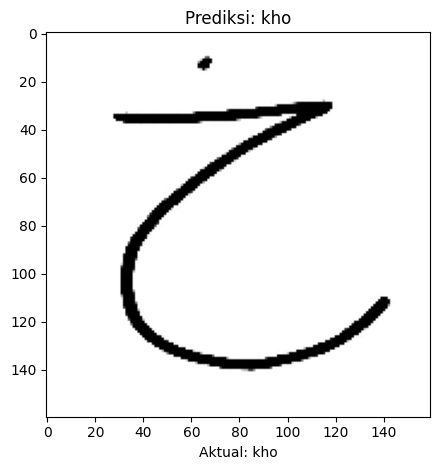

[[9.7722939e-08 2.4674677e-21 7.7783602e-10 1.3856608e-14 4.6354048e-10
  5.1428989e-10 3.5515571e-12 4.6596873e-09 9.2111177e-06 2.6364755e-12
  1.6526142e-04 1.4241382e-10 2.3028274e-08 2.5975978e-15 9.9999825e+01
  8.6296456e-12 3.2017575e-10 1.3115621e-14 1.8630797e-09 3.2912446e-08
  2.4356252e-13 3.7439070e-09 3.5003406e-11 1.3215862e-11 1.6602381e-11
  1.7740713e-12 1.8831594e-15 1.3758489e-13 2.2028632e-07 1.6165518e-13]]


In [ ]:
# load data uji
huruf = input("Nama huruf: ")
img_path = 'dataset/' + VAL_DATA + '/' + huruf + '/'+ huruf + '_5.jpg'
new_image = load_image(img_path)

# prediksi
pred = loaded_model.predict(new_image)
pred *= 100
print(np.argmax(pred))

img = load_img(img_path, target_size=(160, 160))
plt.imshow(img)
plt.title("Prediksi: {}".format(class_names[np.argmax(pred)]))
plt.xlabel("Aktual: " + img_path.split("/")[2])
plt.tight_layout()
plt.show()
print(pred)

Pengguna diminta untuk mengupload gambar yag berisi huruf hijaiyah dan sistem akan mempredisi huruf tersebut

In [ ]:
# Pengujian GUI

from ipywidgets import *
from IPython.display import clear_output, display
from tkinter import Tk, filedialog

def select_files(file):
    clear_output()
    root = Tk()
    root.withdraw() # Hide the main window.
    root.call('wm', 'attributes', '.', '-topmost', True) # Raise the root to the top of all windows.
    file.files = filedialog.askopenfilename(multiple=True) # List of selected files will be set button's file attribute.
    print(file.files) # Print the list of files selected.

1/1 [==============================] - 0s 85ms/step


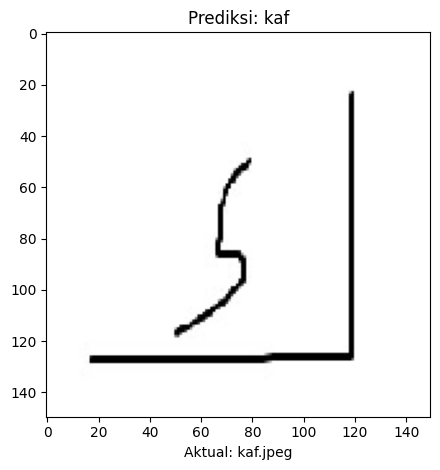

[[8.7850075e-03 5.8961144e-14 7.2787657e-08 3.6430433e-07 2.4716191e-03
  4.5707638e-09 2.4447672e-03 4.7470741e-02 6.8193980e-02 9.7656026e-05
  8.5114971e-07 2.9605999e-06 4.8935478e-09 6.8843735e+01 2.2713986e-07
  6.0619618e-04 2.6054200e-02 4.3223031e-07 1.9706467e-06 2.8714654e-03
  5.4863966e-07 6.2391884e-03 2.5427526e+01 2.2933681e-03 8.7880467e-11
  5.5447292e+00 9.3830521e-13 1.2735642e-02 3.7310510e-03 5.1574831e-11]]


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import load_model
from ipywidgets import FileUpload, Output
from IPython.display import display, clear_output
import io

# Load model
loaded_model = load_model('models/hijaiyah.h5')

# Daftar nama kelas berdasarkan urutan folder
class_names = ['ain', 'alif', 'ba', 'dal', 'dhod', 'dzal', 'dzho', 'fa', 'ghoin', 'ha', 'ha\'', 'hamzah', 'jim',
               'kaf', 'kho', 'lam', 'lamalif', 'mim', 'nun', 'qof', 'ro', 'shod', 'sin', 'syin', 'ta', 'tho', 'tsa',
               'wawu', 'ya', 'zain']

# Fungsi untuk memuat dan memproses gambar
def load_image(img_path, target_size=(150, 150)):
    img = load_img(img_path, target_size=target_size)
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Normalisasi gambar
    return img_array

# Fungsi untuk menampilkan gambar dan prediksi
def display_prediction(image_data, file_name):
    new_image = load_image(io.BytesIO(image_data))
    pred = loaded_model.predict(new_image)
    pred *= 100
    predicted_class = class_names[np.argmax(pred)]

    img = load_img(io.BytesIO(image_data), target_size=(150, 150))
    plt.imshow(img)
    plt.title(f"Prediksi: {predicted_class}")
    plt.xlabel(f"Aktual: {file_name.split('_')[0]}")
    plt.tight_layout()
    plt.show()
    print(pred)

# Fungsi untuk menangani unggahan file
def on_file_upload(change):
    clear_output()
    for name, file_info in change['new'].items():
        display_prediction(file_info['content'], name)

# Widget untuk unggah file
upload = FileUpload(accept='.jpg, .jpeg, .png', multiple=False)
upload.observe(on_file_upload, names='value')
display(upload)


Alur Kerja Kode
Inisialisasi variabel total dan betul.
Iterasi melalui setiap folder (kelas) dalam class_names.
Iterasi melalui setiap gambar dalam folder tersebut.
Memuat dan memproses gambar.
Melakukan prediksi menggunakan model.
Memeriksa apakah prediksi sesuai dengan kelas aktual.
Menghitung jumlah prediksi yang benar dan total gambar yang diuji.
Menghitung dan mencetak akurasi.

In [ ]:
# Menghitung akurasi secara manual
total = 0
betul = 0
for folder in class_names:
    for count, filename in enumerate(os.listdir(os.path.join(VALIDATION_DIR, folder))):
        img_path = 'dataset/' + VAL_DATA + '/' + folder + '/'+ filename
        new_image = load_image(img_path)
        pred = loaded_model.predict(new_image)
        if class_names[np.argmax(pred)] == folder:
            betul += 1
        total += 1

print("Akurasi pada data tes: {}%".format((betul/total)*100))

1/1 [==============================] - 0s 17ms/step
Akurasi pada data tes: 99.76190476190476%


 Setiap baris yang ditampilkan adalah satu iterasi prediksi untuk satu gambar, dan waktu eksekusi (dalam milidetik) untuk melakukan prediksi.

## Confusion Matrix

In [ ]:
# Confusion Matrix dan Classification Report
Y_pred = []

for folder in class_names:
    for labels, filename in enumerate(os.listdir(os.path.join(VALIDATION_DIR, folder))):
        img_path = 'dataset/' + VAL_DATA + '/' + folder + '/'+ filename
        new_image = load_image(img_path)
        pred = loaded_model.predict(new_image)
        Y_pred.append(np.argmax(pred, axis=1))

1/1 [==============================] - 0s 30ms/step


In [ ]:
# Menampilkan hasil
print('\n=======================Confusion Matrix=======================\n')
print(confusion_matrix(validation_generator.classes, Y_pred))
print('\n\n=================Classification Report=================\n')
target_names = class_names
print(classification_report(validation_generator.classes, Y_pred, target_names=target_names))


=======================Confusion Matrix=======================

[[14  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0]
 [ 0 14  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0]
 [ 0  0 14  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0]
 [ 0  0  0 14  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0]
 [ 0  0  0  0 14  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0]
 [ 0  0  0  0  0 14  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0]
 [ 0  0  0  0  0  0 14  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 14  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 14  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 14  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  

Confusion matrix di atas adalah matriks 30x30 karena ada 30 kelas huruf Hijaiyah yang berbeda
- Semua nilai diagonal (seperti [0, 0], [1, 1], [2, 2], dll.) adalah 14, menunjukkan bahwa semua instance dari setiap kelas diklasifikasikan dengan benar sebanyak 14 kali.
- Hampir semua elemen non-diagonal adalah 0, yang berarti tidak ada kesalahan klasifikasi untuk hampir semua kelas.
- Ada satu elemen [20, 29] yang nilainya adalah 1, menunjukkan bahwa ada satu instance kelas zain yang diprediksi sebagai kelas ro.

classification report:

- Precision, Recall, dan F1-score untuk hampir semua kelas adalah 1.00, menunjukkan bahwa model memiliki kinerja yang sangat baik dalam mengklasifikasikan huruf-huruf Hijaiyah.
- Support untuk setiap kelas adalah 14, yang berarti ada 14 instance untuk setiap kelas dalam dataset.
- Kelas ro memiliki precision sedikit lebih rendah (0.93) karena ada satu instance yang salah diklasifikasikan sebagai zain.
- Kelas zain memiliki recall sedikit lebih rendah (0.93) karena satu instance dari kelas ini salah diklasifikasikan sebagai ro.

Kesimpulan Dari confusion matrix dan classification report, kita dapat menyimpulkan bahwa model klasifikasi huruf Hijaiyah ini memiliki kinerja yang sangat baik dengan akurasi total 1.00 (atau mendekati 1.00 dengan beberapa kesalahan kecil). Model ini sangat efisien dalam mengklasifikasikan huruf Hijaiyah dengan tingkat kesalahan yang sangat rendah.